# *Some preprocessing on the device and importing the required libraries.*

In [2]:
import tensorflow as tf  
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import sklearn
import matplotlib.image as mpimg

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

plt.style.use('dark_background')

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator # Data Augmentation
from keras.layers import BatchNormalization # Has a very good result and in the speed
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout
from keras.utils import normalize, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l1, l2, l1_l2  
from tensorflow.keras.utils import plot_model

In [4]:
import pydot
import graphviz

In [5]:
# Force memory can only be used by the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Step1: Data acquistion and preprocessing

- ## *1. Labelling all the catergories for the dataset to better visualization after*

In [6]:
# Cache path for CIFAR-100 dataset
cifar100_path = os.path.expanduser('~/.keras/datasets/cifar-100-python')

# Loading metadata files
def load_cifar100_meta(file_path):
    with open(file_path, 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    return meta

# Extract fine-grained category names
meta = load_cifar100_meta(os.path.join(cifar100_path, 'meta'))
fine_label_names = [label.decode('utf-8') for label in meta[b'fine_label_names']]

# Print the category name to confirm
print("CIFAR-100 Fine Label Names:")
print(fine_label_names)
print(f"Total number of fine labels: {len(fine_label_names)}")

CIFAR-100 Fine Label Names:
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardro

In [7]:
label_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
len(label_names)

100

- ## *2. Using One-Hot Encoding on y_train and y_test*

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('The y_train shape has been changed to:',y_train.shape)
print('The y_train shape has been changed to:',y_test.shape)

# The integer labels are converted into a format suitable for the multiclassification task,
# but care needs to be taken with the continuity of the labels and the choice of the loss function.


The y_train shape has been changed to: (50000, 100)
The y_train shape has been changed to: (10000, 100)


*The integer labels are converted into a format suitable for the multiclassification task, but care needs to be taken with the continuity of the labels and the choice of the loss function. Then we will choose the softmax as output activations functions and categorical_crossentropy as loss functions*

# *3.Normalizing the x_train and x_test changing the pixel values from 0-255 into 0-1*

In [9]:

# x_train = preprocess_input(x_train)
# x_test = preprocess_input(x_test)

x_train = normalize(x_train,axis=1)
x_test  = normalize(x_test,axis=1)




In [10]:
x_train

array([[[[0.21733476, 0.20371545, 0.23888911],
         [0.22833628, 0.21287664, 0.25510525],
         [0.23354998, 0.21622215, 0.26106229],
         ...,
         [0.31908313, 0.36437089, 0.42761323],
         [0.3394965 , 0.37051932, 0.43367069],
         [0.29095579, 0.31267596, 0.34960657]],

        [[0.21733476, 0.20371545, 0.23888911],
         [0.22744084, 0.21204183, 0.25410484],
         [0.23263409, 0.21537422, 0.26003852],
         ...,
         [0.27817504, 0.31282574, 0.33234189],
         [0.25782517, 0.27788949, 0.27635877],
         [0.2334041 , 0.24820669, 0.23656013]],

        [[0.21733476, 0.20371545, 0.23888911],
         [0.22744084, 0.21204183, 0.25410484],
         [0.23354998, 0.21622215, 0.26106229],
         ...,
         [0.30926519, 0.35370638, 0.37443853],
         [0.26583216, 0.29443053, 0.27635877],
         [0.19343764, 0.21436032, 0.18213037]],

        ...,

        [[0.12613939, 0.14779356, 0.07400878],
         [0.12715197, 0.15193548, 0.05702353]

## *4. Spliting the training set into validation set*

In [11]:
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=np.argmax(y_train, axis=1)  # ensure all the catergories distributes the same when running the code each times.
)


## *5. Data Augmentation*

In [12]:
IMG_SIZE = 224
IMAGE = x_train_split[100]


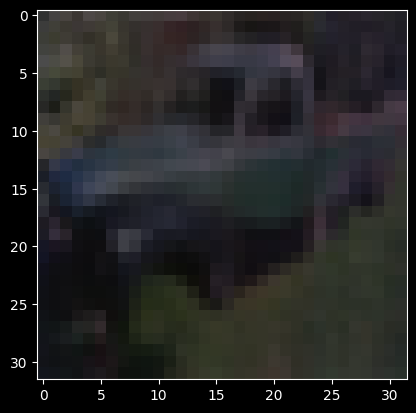

In [13]:
plt.imshow(x_train_split[100])

In [14]:
print("pixel range :", x_train_split.min(), x_train_split.max())
print("data type:", x_train_split.dtype)

pixel range : 0.0 1.0
data type: float64


In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

train_generator = train_datagen.flow(x_train_split,y_train_split) # batch_size=20


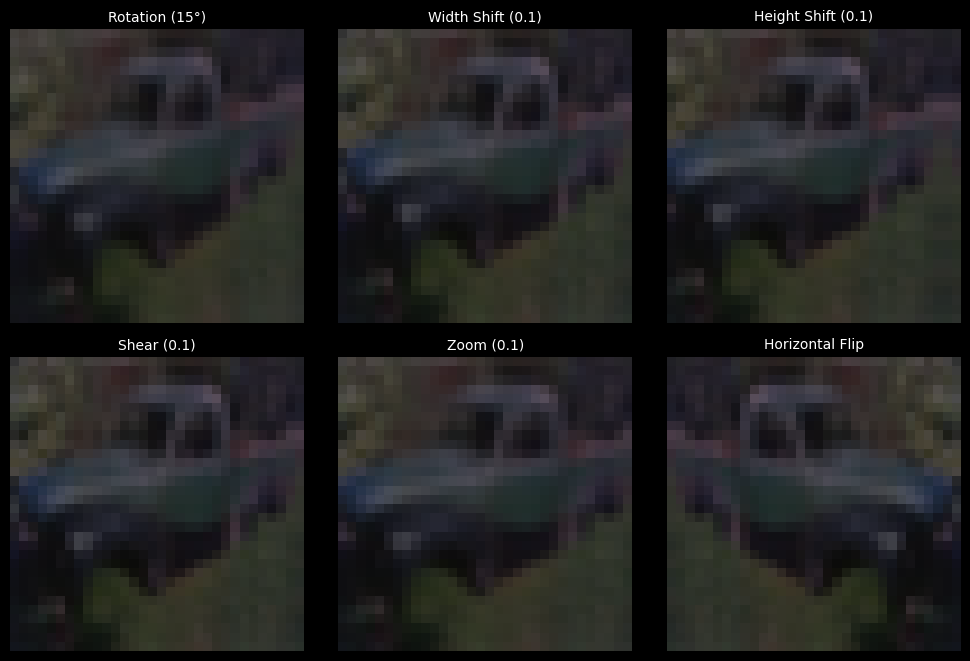

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE = x_train_split[100]  

datagen_rotation = ImageDataGenerator(rotation_range=15, fill_mode='reflect')
datagen_width_shift = ImageDataGenerator(width_shift_range=0.1, fill_mode='reflect')
datagen_height_shift = ImageDataGenerator(height_shift_range=0.1, fill_mode='reflect')
datagen_shear = ImageDataGenerator(shear_range=0.1, fill_mode='reflect')
datagen_zoom = ImageDataGenerator(zoom_range=0.1, fill_mode='reflect')
datagen_flip = ImageDataGenerator(horizontal_flip=True, fill_mode='reflect')

augmented_images = []
titles = [
    "Rotation (15°)",
    "Width Shift (0.1)",
    "Height Shift (0.1)",
    "Shear (0.1)",
    "Zoom (0.1)",
    "Horizontal Flip"
]


augmented_images.append(datagen_rotation.random_transform(IMAGE))  # 旋转
augmented_images.append(datagen_width_shift.random_transform(IMAGE))  # 宽度平移
augmented_images.append(datagen_height_shift.random_transform(IMAGE))  # 高度平移
augmented_images.append(datagen_shear.random_transform(IMAGE))  # 剪切
augmented_images.append(datagen_zoom.random_transform(IMAGE))  # 缩放
augmented_images.append(datagen_flip.random_transform(IMAGE))  # 水平翻转


plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.title(titles[i], fontsize=10)  
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Printing all the dataset shapes
print("Dataset Shapes".center(50, '-'))
print(f"{'Training set x shape:':<25} {x_train.shape}")
print(f"{'Validation set x shape:':<25} {x_val.shape}")
print(f"{'Testing set x shape:':<25} {x_test.shape}")
print(f"{'Training set y shape:':<25} {y_train.shape}")
print(f"{'Validation set y shape:':<25} {y_val.shape}")
print(f"{'Testing set y shape:':<25} {y_test.shape}")
print("-" * 50)

------------------Dataset Shapes------------------
Training set x shape:     (50000, 32, 32, 3)
Validation set x shape:   (10000, 32, 32, 3)
Testing set x shape:      (10000, 32, 32, 3)
Training set y shape:     (50000, 100)
Validation set y shape:   (10000, 100)
Testing set y shape:      (10000, 100)
--------------------------------------------------


*Checking the values of y_train and x_train beforehand to check* 

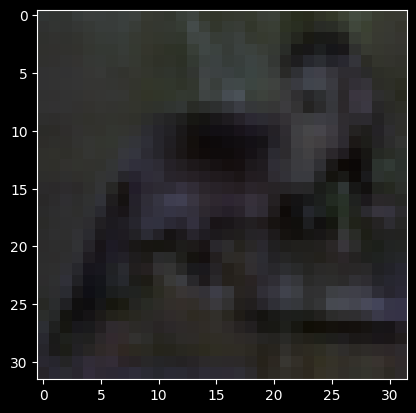

In [17]:
plt.imshow(x_train[100])

In [18]:
y_train[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [19]:
x_train[100]

array([[[0.19483839, 0.20835087, 0.20566984],
        [0.19492628, 0.206924  , 0.19951552],
        [0.19446482, 0.20624124, 0.19602544],
        ...,
        [0.22683494, 0.23619606, 0.19527996],
        [0.22111425, 0.22529562, 0.18892498],
        [0.22342626, 0.22588712, 0.19586114]],

       [[0.18838678, 0.19532894, 0.18892927],
        [0.19761492, 0.2039251 , 0.19951552],
        [0.195844  , 0.2016239 , 0.19344616],
        ...,
        [0.22379018, 0.22954265, 0.1928691 ],
        [0.22111425, 0.22360166, 0.19679685],
        [0.20926544, 0.20902987, 0.17976297]],

       [[0.18709646, 0.18954142, 0.17936323],
        [0.19358196, 0.1949284 , 0.1870458 ],
        [0.19032727, 0.19238922, 0.18054975],
        ...,
        [0.22074542, 0.22621594, 0.1928691 ],
        [0.21954606, 0.22190771, 0.19942081],
        [0.21241229, 0.21071559, 0.19049509]],

       ...,

       [[0.15225781, 0.14613499, 0.16979719],
        [0.10620122, 0.10496145, 0.1022517 ],
        [0.11171383, 0

In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Dropout,GlobalAveragePooling2D 
from keras import backend as K

In [21]:
IMAGE_HEIGHT= x_train.shape[1]
IMAGE_WIDTH = x_train.shape[2]
IMAGE_CHANNELS= x_train.shape[3]

## Step2: Building a simple CNN model first

*This is an initial version of CNN model that I built, it is used to gain a basic understanding of an overview framework for this Multi-classification task as an initial experiment.*

*Some very vital model parameters definition which help better understand the model*
- *Loss function (categorial crossentropy) : Quantifies the error between output of the algorithm and given target value, in order to find the golabl minimum value by the optimizer shown here as adam.*

- *evaluated metrics: accuracy defined by the corrected number rate.*

- *Optimizers update the model in response to the output of the loss function.*

- *activation functions: importing non-linear factor to the results*

In [ ]:
# CNN-1 model structures: 
# activation = 'relu'
# model1 = Sequential()
# model1.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
# model1.add(BatchNormalization())

# model1.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model1.add(BatchNormalization())
# model1.add(MaxPooling2D())

# model1.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model1.add(BatchNormalization())

# model1.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model1.add(BatchNormalization()) 
# model1.add(MaxPooling2D())

# model1.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model1.add(BatchNormalization())

# model1.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model1.add(BatchNormalization()) 
# model1.add(MaxPooling2D())

# model1.add(Flatten())
# model1.add(Dense(256, activation = activation, kernel_initializer = 'he_uniform'))
# model1.add(Dense(100, activation = 'softmax'))

# model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
# print(model1.summary()) 

In [ ]:
# CNN-2 model structures: 
# activation = 'relu'
# model2 = Sequential()
# model2.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
# model2.add(BatchNormalization())

# model2.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model2.add(BatchNormalization())
# model2.add(MaxPooling2D())

# model2.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model2.add(BatchNormalization())

# model2.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model2.add(BatchNormalization()) 
# model2.add(MaxPooling2D())

# model2.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model2.add(BatchNormalization())

# model2.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model2.add(BatchNormalization()) 
# model2.add(MaxPooling2D())

# model2.add(Flatten())
# model2.add(Dense(1026, activation = activation, kernel_initializer = 'he_uniform'))
# model2.add(Dense(100, activation = 'softmax'))

# model1.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
# print(model2.summary()) 

In [ ]:
# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=r"C:\vscodeproject\Python\EE992\model_weight\model_first_augmented_weight.h5", 
#         save_best_only=True, 
#         verbose=1,
#         monitor='val_loss', 
#         mode='min'           
#     )]

 
# history1 = model1.fit_generator(
#     train_generator,
#     steps_per_epoch=1000,
#     epochs=50,
#     validation_data=(x_val, y_val),
#     callbacks=callbacks,  
#     verbose=1,
#     shuffle=False
# )


## Building more complex CNN model

In [ ]:

# CNN-3 model structures: 
activation = 'relu'
model3 = Sequential()
model3.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
model3.add(BatchNormalization())

model3.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D())

model3.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model3.add(BatchNormalization())

model3.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model3.add(BatchNormalization()) 
model3.add(MaxPooling2D())

model3.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model3.add(BatchNormalization())

model3.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model3.add(BatchNormalization()) 
model3.add(MaxPooling2D())

model3.add(Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model3.add(BatchNormalization())
model3.add(Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model3.add(BatchNormalization()) 
model3.add(MaxPooling2D())



model3.add(Flatten())
model3.add(Dense(1024, activation = activation, kernel_initializer = 'he_uniform'))
model3.add(Dropout(0.2))
model3.add(Dense(100, activation = 'softmax'))

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model3.summary()) 

In [ ]:
# CNN-4 model structures: 
# activation = 'relu'
# model4 = Sequential()
# model4.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
# model4.add(BatchNormalization())

# model4.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization())
# model4.add(MaxPooling2D())

# model4.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization())

# model4.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization()) 
# model4.add(MaxPooling2D())

# model4.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization())

# model4.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization()) 
# model4.add(MaxPooling2D()) 

# model4.add(Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization())
# model4.add(Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization()) 
# model4.add(MaxPooling2D()) 

# model4.add(Conv2D(512, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization())
# model4.add(Conv2D(512, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
# model4.add(BatchNormalization()) 
# model4.add(MaxPooling2D()) 

# model4.add(Flatten())
# model4.add(Dense(1024, activation = activation, kernel_initializer = 'he_uniform'))
# model4.add(Dropout(0.2))
# model4.add(Dense(100, activation = 'softmax'))

# model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss = 'categorical_crossentropy', metrics = ['accuracy'])
# print(model4.summary()) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [29]:
callback1 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=r"C:\vscodeproject\Python\EE992\model_weight\model3_augmented_best_val_loss_reg.h5", 
        save_best_only=True, 
        verbose=1,
        monitor='val_loss', 
        mode='min'           
    )]

callback2=[tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)]

history3 = model3.fit_generator(
    train_generator,
    steps_per_epoch=1000,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[callback1,callback2],  
    verbose=1,
    shuffle=False
)


Epoch 1/50


C:\Users\15489\AppData\Local\Temp\ipykernel_51764\2487140190.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(


 999/1000 [============================>.] - ETA: 0s - loss: 7.8738 - accuracy: 0.0908
Epoch 1: val_loss improved from inf to 7.03357, saving model to C:\vscodeproject\Python\EE992\model_weight\model3_augmented_best_val_loss_reg.h5
1000/1000 [==============================] - 36s 29ms/step - loss: 7.8729 - accuracy: 0.0909 - val_loss: 7.0336 - val_accuracy: 0.1641 - lr: 1.0000e-04
Epoch 2/50
 999/1000 [============================>.] - ETA: 0s - loss: 6.7603 - accuracy: 0.1675
Epoch 2: val_loss improved from 7.03357 to 6.24077, saving model to C:\vscodeproject\Python\EE992\model_weight\model3_augmented_best_val_loss_reg.h5
1000/1000 [==============================] - 27s 27ms/step - loss: 6.7599 - accuracy: 0.1675 - val_loss: 6.2408 - val_accuracy: 0.2185 - lr: 1.0000e-04
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 6.0054 - accuracy: 0.2135
Epoch 3: val_loss improved from 6.24077 to 5.58614, saving model to C:\vscodeproject\Python\EE992\model_weight\model3_a

## Transfer learning

In [30]:

# IMG_SHAPE = (224,224,3)
# INPUT_SHAPE=(32,32,3)
# inputs=Input(shape=INPUT_SHAPE)
# print(inputs)

In [31]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model

# IMG_SHAPE = (224,224,3)
# INPUT_SHAPE=(32,32,3)


# ###### Using the backbone of ResNet50 Model
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)


# base_model.trainable= False  
# #for layer in base_model.layers[-7:]:
#     #layer.trainable = True#

# inputs=Input(shape=INPUT_SHAPE)
# x = layers.Resizing(224,224)(inputs)
# x = base_model(x)
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# outputs = Dense(100, activation='softmax')(x)

# model3= Model(inputs,outputs)

# model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# print(model3.summary(expand_nested=True,show_trainable=True))

In [32]:
# callbacks1 = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=r"C:\vscodeproject\Python\EE992\model_weight\model3_augmented_best_val_loss_transfer_learning.h5", 
#         save_best_only=True, 
#         verbose=1,
#         monitor='val_loss', 
#         mode='min'           
#     )]


# callback2=[tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0.0,
# )]



# history3 = model3.fit_generator(
#     train_generator,
#     # steps_per_epoch=1000,
#     epochs=10,

#     validation_data=(x_val,y_val),
#     callbacks=[callbacks1,callback2],  
#     verbose=1,
#     shuffle=False
# )


## Step3 : Visualisation of the validation and training sets of the loss and accuracy

- *plot the training and validation accuracy and loss at each epoch*

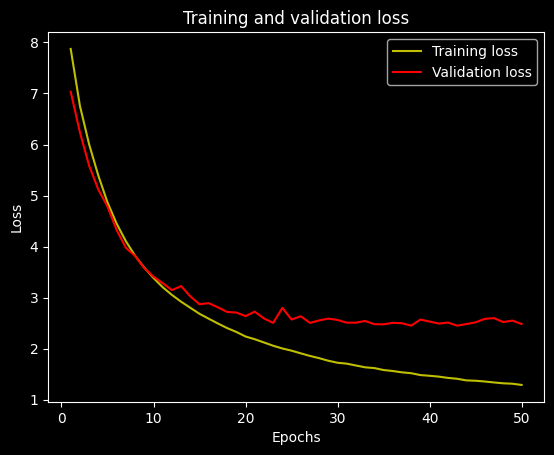

In [33]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


*(These are just the logbook contents record my progressed processing based on the plot. Ticket means what I have done)*

- *Adding more layers*

- *Regularisation(dropout etc)*

- *Data augmentation ✔*

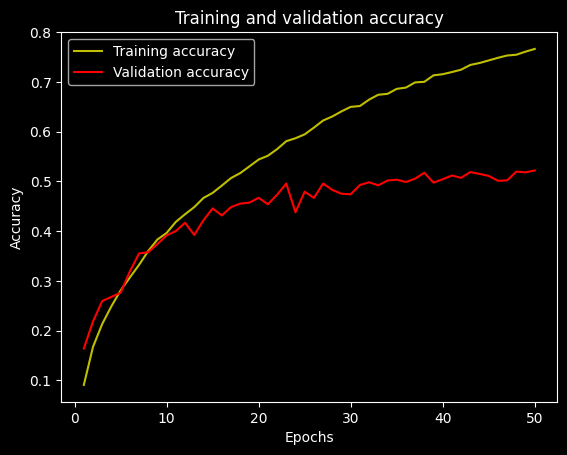

In [34]:

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Step 4: Evaluate the training model on testing set

In [35]:
y_pred = model3.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # Using argmax can return the index of the one-hot vector so that it can tell the certain type of the prediction class
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 3s 9ms/step


In [36]:
print(f'The shape of y_pred is:', y_pred_classes.shape)
print(f'The shape of y_true is:', y_true.shape)

The shape of y_pred is: (10000,)
The shape of y_true is: (10000,)


In [37]:
y_true

array([49, 33, 72, ..., 51, 42, 70], dtype=int64)

In [38]:
# Printing the testing sample
num_samples = 10 # It is adjustable, can be changed to different number from 0-10000.
for i in range(num_samples):
    true_label = fine_label_names[y_true[i]]  # The true label name
    pred_label = fine_label_names[y_pred_classes[i]]  # The predicted type name
    print(f"Sample {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Predicted Label: {pred_label}")
    print(f"  Correct: {true_label == pred_label}\n")

Sample 1:
  True Label: mountain
  Predicted Label: dolphin
  Correct: False

Sample 2:
  True Label: forest
  Predicted Label: forest
  Correct: True

Sample 3:
  True Label: seal
  Predicted Label: crocodile
  Correct: False

Sample 4:
  True Label: mushroom
  Predicted Label: bus
  Correct: False

Sample 5:
  True Label: sea
  Predicted Label: sea
  Correct: True

Sample 6:
  True Label: tulip
  Predicted Label: spider
  Correct: False

Sample 7:
  True Label: camel
  Predicted Label: turtle
  Correct: False

Sample 8:
  True Label: butterfly
  Predicted Label: shrew
  Correct: False

Sample 9:
  True Label: cloud
  Predicted Label: mountain
  Correct: False

Sample 10:
  True Label: apple
  Predicted Label: apple
  Correct: True



- *Visualization the images and categories*

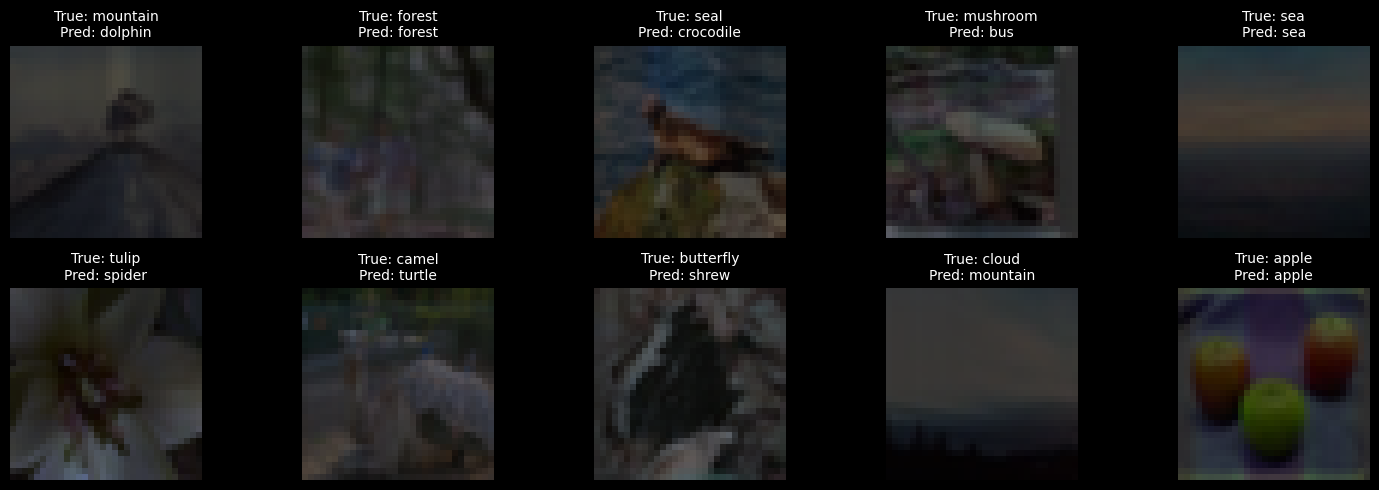

In [39]:
# Visualisation of the images and categories for the first 10 images
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i])  # Showing the x_test data images
    true_label = fine_label_names[y_true[i]] # showing the true label catergories
    pred_label = fine_label_names[y_pred_classes[i]] # showing the prediction catergories
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

Script(record the operations that I have tried):
- 1. After adding data augmentation the correct item improved from 1 to 2.
- 2. After optimizing the data augmentation hyperparameters such as the rotation_range from 45% to 15%, the correct itemes improved from 2 to 4.

## *Step5: Confusion matrix visualisation and classification report*

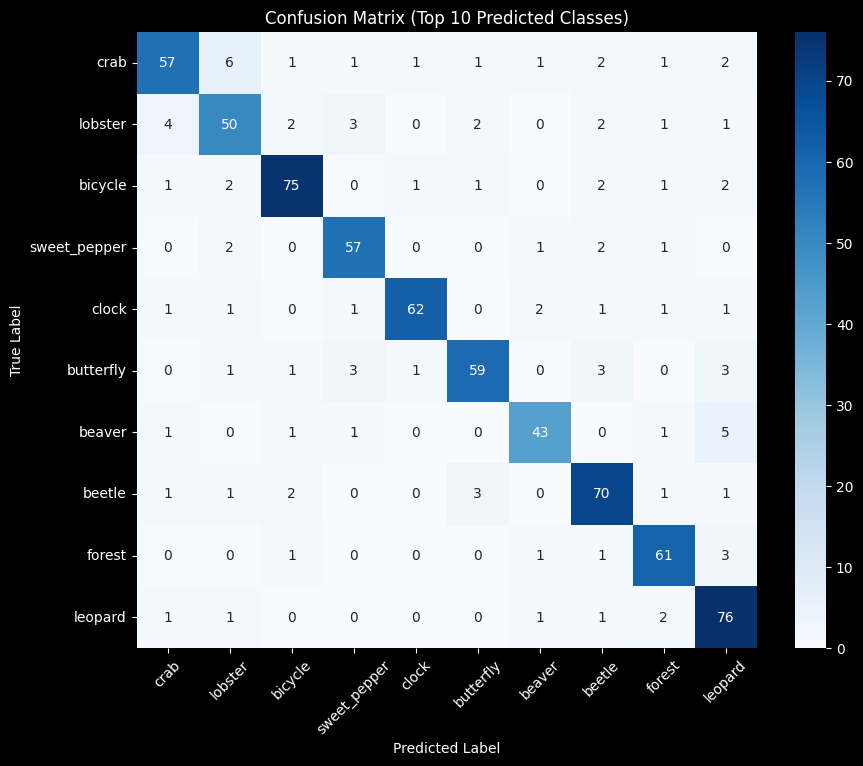

In [40]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Find the top 10 catergories for better visualization the 100 X 100 confusion matrix otherwise it will be too dense to see the matrix.
top_k = 10
# Calculate the total number of predictions for each category (off-diagonal sum)
pred_counts = cm.sum(axis=0)  #  The sum of each column, indicating the total number projected for the category
top_k_indices = np.argsort(pred_counts)[-top_k:]  # Index of the top 10 most predicted categories

# Extracting the sub confusion matrix
sub_cm = cm[np.ix_(top_k_indices, top_k_indices)]
sub_label_names = [label_names[i] for i in top_k_indices]

# Visualiza the sub confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(sub_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sub_label_names, yticklabels=sub_label_names)
plt.title('Confusion Matrix (Top 10 Predicted Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [41]:
# The classification report
report = classification_report(y_true, y_pred_classes, target_names=label_names)
print(report) # Precision =TP/ TP+FP ; Recall = TP/TP+FN

               precision    recall  f1-score   support

        apple       0.77      0.72      0.75       100
aquarium_fish       0.56      0.71      0.63       100
         baby       0.51      0.35      0.42       100
         bear       0.35      0.30      0.32       100
       beaver       0.26      0.43      0.33       100
          bed       0.55      0.56      0.55       100
          bee       0.54      0.70      0.61       100
       beetle       0.42      0.70      0.52       100
      bicycle       0.50      0.75      0.60       100
       bottle       0.80      0.61      0.69       100
         bowl       0.39      0.37      0.38       100
          boy       0.42      0.26      0.32       100
       bridge       0.53      0.61      0.57       100
          bus       0.41      0.52      0.46       100
    butterfly       0.37      0.59      0.45       100
        camel       0.57      0.38      0.46       100
          can       0.57      0.58      0.58       100
       ca

In [42]:
test_loss, test_accuracy = model3.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 [==============================] - 5s 14ms/step - loss: 2.4343 - accuracy: 0.5335
Test Loss: 2.4343
Test Accuracy: 0.5335
